In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
import datetime
import matplotlib.pyplot as plt
import requests
import json
import joblib
from tvDatafeed import TvDatafeed, Interval

In [30]:
def tune_alpha(x_train,x_validate,y_train,y_validate):
    alp =np.logspace(-4, 4, 1000).tolist()
    column_names = ["alpha", "RMSE","MAE"]
    data =[]
    for i in alp:
        model = Ridge(alpha=i)
        model.fit(x_train, y_train)
        y_validate_predict = model.predict(x_validate)
        rmse=mean_squared_error(y_validate, y_validate_predict, squared=False)
        mae=mean_absolute_error(y_validate, y_validate_predict)
        data.append([i,rmse,mae])
    df = pd.DataFrame(data, columns=column_names)    
    return df

In [31]:
bitcoin = pd.read_pickle("../data/cleaned/bitcoin_value_2020-now_cleaned.pkl")
sentiment = pd.read_pickle("../data/cleaned/by_date_verified_weighted_sentiment_2020-2021.pkl")
money = pd.read_pickle("../data/cleaned/by_date_verified_weighted_money_2020-2021.pkl")
add_merge = pd.merge(sentiment,money,on='created_at')
bitcoin = bitcoin.merge(add_merge,left_on='datetime',right_on='created_at').copy()
required_features = ['open_bitcoin','open_eth','open_bnb','open_ada','value_number_transaction','value_number_address','value_transaction_second','value_total_bitcoin','value_hash_rate','weighted_sentiment']
output_label = ['close_bitcoin']
x_set=bitcoin[required_features].copy()
y_set=bitcoin[output_label].copy()

In [32]:
corr = x_set.corr()

<AxesSubplot:>

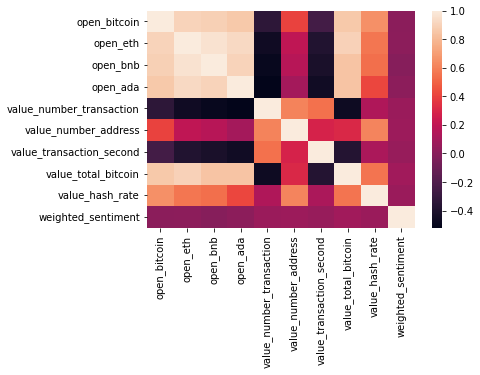

In [33]:
sns.heatmap(corr)

In [34]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.95:
            if columns[j]:
                columns[j] = False
selected_columns = x_set.columns[columns]
x_set = x_set[selected_columns]

In [35]:
selected_features = selected_columns

In [47]:
selected_features

Index(['open_bitcoin', 'open_eth', 'open_ada', 'value_number_transaction',
       'value_number_address', 'value_transaction_second',
       'value_total_bitcoin', 'value_hash_rate', 'weighted_sentiment'],
      dtype='object')

In [36]:
num_train=int(0.7*len(x_set))
num_valid=int(0.85*len(x_set))
x_train = x_set[0:num_train].copy()
x_validate = x_set[num_train:num_valid].copy()
x_test = x_set[num_valid:(len(x_set)-1)].copy()

scaler = StandardScaler().fit(x_train)
x_train[selected_features] = scaler.transform(x_train[selected_features]).copy()
x_validate[selected_features] = scaler.transform(x_validate[selected_features]).copy()
x_test[selected_features] = scaler.transform(x_test[selected_features]).copy()

y_train = y_set[0:num_train].copy()
y_validate = y_set[num_train:num_valid].copy()
y_test = y_set[num_valid:(len(y_set)-1)].copy()

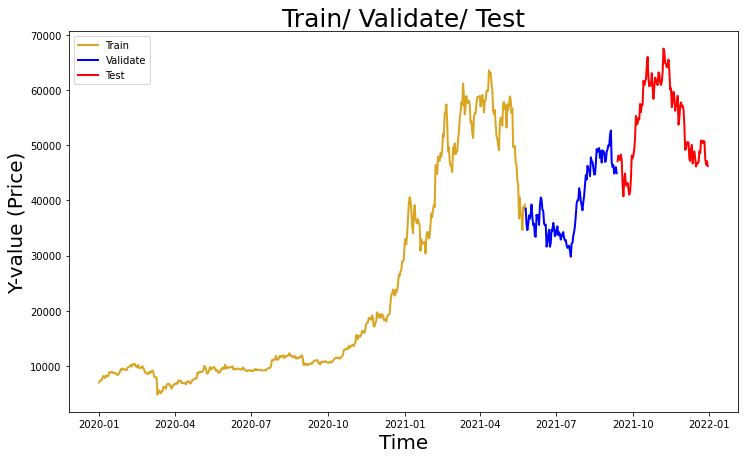

In [37]:
plt.figure(figsize = (12, 7))
plt.plot(bitcoin["datetime"][0:num_train], y_train["close_bitcoin"], color='goldenrod', lw=2)
plt.plot(bitcoin["datetime"][num_train:num_valid], y_validate["close_bitcoin"], color='blue', lw=2)
plt.plot(bitcoin["datetime"][num_valid:(len(y_set)-1)], y_test["close_bitcoin"], color='red', lw=2)
plt.title("Train/ Validate/ Test", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("Y-value (Price)", size=20)
plt.legend(['Train', 'Validate', 'Test'])
plt.show()

In [38]:
df=tune_alpha(x_train,x_validate,y_train,y_validate)
tuned_alpha=df[df.RMSE == df.RMSE.min()].alpha.values[0]
tuned_alpha2=df[df.MAE == df.MAE.min()].alpha.values[0]
tuned_alpha

4.331483223376403

In [39]:
model = Ridge(alpha=tuned_alpha)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [40]:
d={'Feature':x_train.columns,'Coefficients':model.coef_[0]}

In [41]:
df = pd.DataFrame(d)   
df

,Feature,Coefficients
0,open_bitcoin,16745.432336
1,open_eth,-203.988411
2,open_ada,462.813185
3,value_number_transaction,-453.123861
4,value_number_address,795.313595
5,value_transaction_second,23.449226
6,value_total_bitcoin,-170.157767
7,value_hash_rate,374.990962
8,weighted_sentiment,-40.002404


In [42]:
print("Root Mean Squared Error:", mean_squared_error(y_test, y_pred,squared=False))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("R2 score:", r2_score(y_test, y_pred))

Root Mean Squared Error: 2030.9207636468273
Mean Absolute Error: 1643.1876089115099
R2 score: 0.91878122678741


In [43]:
y_result = y_test.copy()
temp = y_pred.tolist()
y_result["close_bitcoin_pred"] = [np_float[0] for np_float in temp]
y_result.rename(columns={"close_bitcoin":"close_bitcoin_true"},inplace=True)
temp2 = bitcoin["datetime"].copy()
y_result = pd.merge(y_result, temp2, left_index=True, right_index=True)
y_result.tail()

,close_bitcoin_true,close_bitcoin_pred,datetime
725,50701.44,50219.526078,2021-12-26
726,47543.74,50162.734736,2021-12-27
727,46464.66,47397.100559,2021-12-28
728,47120.87,45810.210957,2021-12-29
729,46216.93,46805.446322,2021-12-30


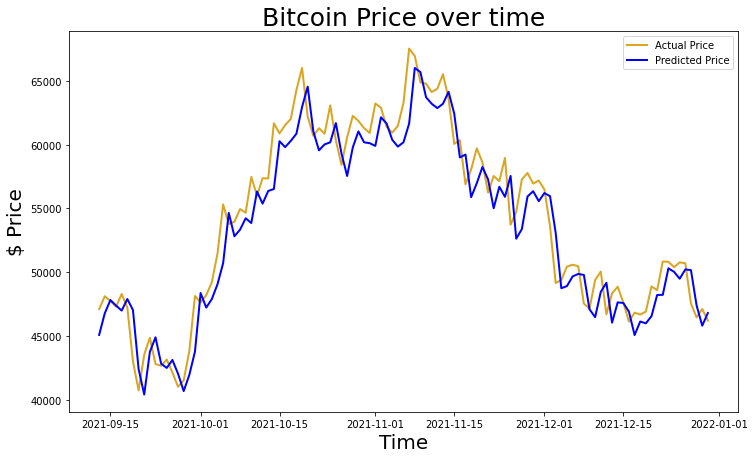

In [44]:
plt.figure(figsize = (12, 7))
plt.plot(y_result["datetime"], y_result["close_bitcoin_true"], color='goldenrod', lw=2)
plt.plot(y_result["datetime"], y_result["close_bitcoin_pred"], color='blue', lw=2)
plt.title("Bitcoin Price over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("$ Price", size=20)
plt.legend(['Actual Price', 'Predicted Price'])
plt.show()

In [45]:
joblib.dump(model, 'savedmodel.pkl')
joblib.dump(scaler, 'savedscaler.pkl')

model_from_joblib = joblib.load('savedmodel.pkl')
scaler_from_joblib = joblib.load('savedscaler.pkl')

model_from_joblib.predict(x_test)[-1]


array([46805.44632216])

In [46]:
y_pred[-1]

array([46805.44632216])